# MNIST

## import libraries

In [2]:
import os
import json

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms.v2 as v2

from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from PIL import Image

import matplotlib.pyplot as plt


## Dataset

In [3]:
transforms = v2.ToPILImage()

dataset

In [4]:
MNIST_train = torchvision.datasets.MNIST('./data/mnist', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./data/mnist', download=True, train=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 510kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.71MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.74MB/s]


folders

In [5]:
if not os.path.exists('./dataset'):
  os.mkdir('./dataset')

  for info in ('train', 'test'):
    os.mkdir(os.path.join('./dataset', info))
    for i in range(10):
      os.mkdir(os.path.join('./dataset', info, f'class_{i}'))

In [6]:
for info in (('train', MNIST_train), ('test', MNIST_test)):
  for i in range(10):
    path = os.path.join('./dataset', info[0], f'class_{i}')
    cls = info[1].data[info[1].targets == i]
    for n, x in enumerate(cls):
      x = transforms(x)
      x.save(os.path.join(path, f'img_{n}.png'), 'png')

json file

In [7]:
targets = dict()
for i in range(10):
  targets[f'class_{i}'] = i

fp = open('/content/dataset/format.json', 'w')
json.dump(targets, fp)
fp.close()

## ImageFolder

In [8]:
to_tensor = v2.Compose([v2.ToTensor(), v2.Grayscale(),
                        v2.ToDtype(torch.float32, scale=True),
                        v2.Lambda(lambda x: x.ravel())])

d_train = ImageFolder('dataset/train', transform=to_tensor)
d_test = ImageFolder('dataset/test', transform=to_tensor)

/usr/local/lib/python3.12/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


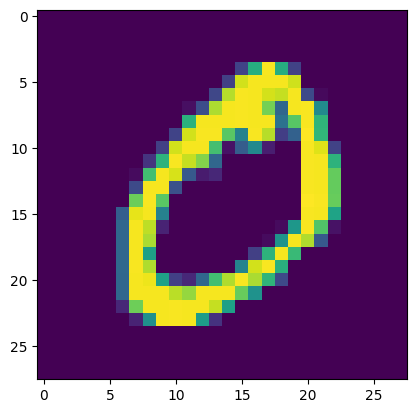

In [9]:
plt.imshow((d_train[0][0]*255).reshape(28, 28))

## Dataloader

In [10]:
batch_size = 100

train_loader = data.DataLoader(d_train, batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(d_test, batch_size=batch_size, shuffle=False)

In [11]:
len(train_loader), len(d_train)

(600, 60000)

## Class NN

In [12]:
class NN_mnist(nn.Module):
  def __init__(self, input_dim, num_hidden, output_dim):
    super().__init__()
    self.layer1 = nn.Linear(input_dim, num_hidden)
    self.layer2 = nn.Linear(num_hidden, output_dim)

  def forward(self, x):
    x = self.layer1(x)
    x = nn.functional.relu(x)
    x = self.layer2(x)

    return x

In [13]:
model = NN_mnist(28*28, 32, 10)

## Train

In [14]:
optimizer = optim.Adam(params=model.parameters(), lr=0.01)
loss_f = nn.CrossEntropyLoss()

epochs= 5

In [15]:
model.train()

for _ in range(epochs):
  for x_train, y_train in train_loader:
    output = model(x_train)
    loss = loss_f(output, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

## Test

In [16]:
model.eval()
Q=0

for x_test, y_test in test_loader:
  with torch.no_grad():
    output = model(x_test)

    output = torch.argmax(output, dim=1)

    Q += torch.sum(output==y_test).item()

print(Q / len(d_test))

0.955


## save/load model

In [17]:
st = model.state_dict()
st

OrderedDict([('layer1.weight',
              tensor([[-0.0293, -0.0207,  0.0223,  ...,  0.0317, -0.0174,  0.0009],
                      [ 0.0160, -0.0206, -0.0142,  ...,  0.0072, -0.0192, -0.0310],
                      [-0.0024,  0.0101,  0.0280,  ..., -0.0063,  0.0191, -0.0201],
                      ...,
                      [-0.0175, -0.0067, -0.0188,  ...,  0.0060,  0.0109,  0.0099],
                      [ 0.0041,  0.0351,  0.0097,  ...,  0.0215, -0.0030,  0.0060],
                      [-0.0243,  0.0234,  0.0253,  ..., -0.0047, -0.0259, -0.0058]])),
             ('layer1.bias',
              tensor([ 0.2968, -0.2491, -0.1086, -0.5700,  0.6919,  0.0662, -0.0802, -0.5909,
                      -0.0933, -0.0959, -0.0357,  0.6161, -0.2809, -0.2615, -0.0312, -0.1622,
                      -0.0486,  1.1576, -0.3161,  0.4705,  0.8834, -0.5877, -0.1015,  0.4841,
                      -0.0759, -0.2747, -0.0661,  0.1404, -0.5162,  0.9774, -0.0678,  0.3783])),
             ('layer2.weigh

In [18]:
torch.save(st, 'model_dnn.tar')

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [21]:
st_dict = torch.load('model_dnn.tar', weights_only=True, map_location=device)

In [24]:
model1 = NN_mnist(28*28, 32, 10)
model2 = NN_mnist(28*28, 32, 10)
model2.load_state_dict(st_dict)

<All keys matched successfully>

In [27]:
for i, model in enumerate([model1, model2]):
  Q=0
  for x_test, y_test in test_loader:
    with torch.no_grad():
      output = model(x_test)

      output = torch.argmax(output, dim=1)

      Q += torch.sum(output==y_test).item()

  print(Q / len(d_test), f'model: {i+1}')

0.0743 model: 1
0.955 model: 2


## Model train 2

In [35]:
from tqdm import tqdm

In [37]:
model = NN_mnist(28*28, 32, 10)

optimizer = optim.Adam(params=model.parameters(), lr=0.01)
loss_f = nn.CrossEntropyLoss()

epochs= 5

In [38]:
model.train()

best_loss = 1e10
for epoch in range(epochs):
  loss_mean = 0
  lm_count = 0

  train_tqdm = tqdm(train_loader, leave=True)
  for x_train, y_train in train_tqdm:
    output = model(x_train)
    loss = loss_f(output, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lm_count += 1
    loss_mean = 1/lm_count*loss.item() + (1-1/lm_count)*loss_mean

  if best_loss > loss_mean * 1.1:
    best_loss = loss_mean
    st = model.state_dict()
    torch.save(st, f'model_dnn_{epoch+1}.tar')

100%|██████████| 600/600 [00:25<00:00, 23.81it/s]
